Based on https://colab.research.google.com/github/pycaret/pycaret/blob/master/tutorials/time_series/forecasting/univariate_with_exogeneous_part3.ipynb?authuser=2#scrollTo=tJ6nAsuKYYE0

# Pre-setup


In [3]:
# Importe a biblioteca os para manipulação do ambiente
import os

# Configure a variável de ambiente para definir o nível de logging como "CRITICAL"
# Isso é opcional e pode ser usado para suprimir mensagens de log indesejadas
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

# A partir deste ponto, o PyCaret usará um nível de logging crítico, suprimindo mensagens menos importantes.
# Isso é útil se você quiser reduzir a quantidade de saída do console durante a execução do PyCaret.

In [4]:
def verificar_pacotes_instalados():
    # Importa a função show_versions do PyCaret
    from pycaret import show_versions

    # Exibe as versões instaladas
    show_versions()

# Tenta executar a função para verificar os pacotes instalados
try:
    verificar_pacotes_instalados()
except ModuleNotFoundError:
    # Se a exceção ModuleNotFoundError for levantada, instala o PyCaret usando o pip
    !pip install pycaret

    # Executa novamente a função para verificar os pacotes instalados após a instalação
    verificar_pacotes_instalados()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.9/483.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 24.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 101.8 MB/s

In [5]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

In [6]:
# Global Figure Settings for notebook ----

# Depending on whether you are using jupyter notebook, jupyter lab, Google Colab, you may have to set the renderer appropriately
# NOTE: Setting to a static renderer here so that the notebook saved size is reduced.
global_fig_settings = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

# Este trecho de código define um dicionário chamado global_fig_settings que contém configurações globais para figuras.
# O renderizador está definido como "png" para reduzir o tamanho do arquivo ao salvar o notebook.
# Você pode alternar para "notebook" dependendo do ambiente que você está usando (Jupyter Notebook, Jupyter Lab, etc.).
# As configurações também incluem largura e altura da figura. O comentário fornece informações adicionais sobre a opção
# de renderizador e sua influência no tamanho do arquivo ao salvar o notebook.

In [7]:
# Instala o pacote pyreadr usando o comando pip
!pip install pyreadr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 5.1 MB/s eta 0:00:00


In [8]:
# Instala o pacote yfinance usando o comando pip
!pip install yfinance

# Carregar Dados

## Carregar Dados Textuais que foram Pre-processados no R

- Baixar um arquivo RDS (do R) de uma URL
- Carregar os dados usando pyreadr
- Realizar algumas operações de manipulação de dados (seleção de colunas, agrupamento, pivotagem) e;
- Finalmente cria uma tabela pivô chamada text_data com índice 'data', colunas 'palavra' e valores 'tf_idf'.

In [9]:
# Importa a biblioteca pyreadr
import pyreadr

# URL do arquivo RDS que será baixado
url = 'https://github.com/gustavocxavier/g1-bolsa/raw/main/serie_noticias.rds'

# Caminho de destino para salvar o arquivo baixado localmente
dst_path = "/serie_noticias.rda"

# Baixa o arquivo RDS do URL e carrega os dados usando pyreadr
text_data = pyreadr.read_r(pyreadr.download_file(url, '/serie_noticias.rds'))[None]
print(text_data)

            data  documento      palavra  frequencia    tf_idf  \
0     2020-12-28          1      imposto           5  0.101107   
1     2020-12-28          2     otimismo           3  0.094824   
2     2020-12-29         32      imposto           3  0.120450   
3     2020-12-29         36    confianca           5  0.147875   
4     2020-12-30         41  fragilidade           2  0.142999   
...          ...        ...          ...         ...       ...   
5124  2023-05-09      20991      artista           7  0.061279   
5125  2023-05-09      20997        morte           5  0.063227   
5126  2023-05-09      21000    seguranca           8  0.095084   
5127  2023-05-09      21009     confusao           2  0.064311   
5128  2023-05-09      21012      deboche           3  0.055372   

     grammar_category  polarity polarity_target polarity_classification  \
0                 Adj      -1.0              N0                    JALC   
1                   N       1.0              N0          

In [2]:
# Seleciona apenas as colunas 'data', 'palavra' e 'tf_idf'
text_data = text_data[['data', 'palavra', 'tf_idf']]

# Agrupa os dados por 'data' e 'palavra', calcula a média da coluna 'tf_idf' para duplicatas
text_data = text_data.groupby(['data', 'palavra'], as_index=False)['tf_idf'].mean()

# Converte os dados para um formato de tabela pivô usando 'data' como índice, 'palavra' como coluna e 'tf_idf' como valor
# Preenche valores ausentes com 0
text_data = text_data.pivot(index='data', columns='palavra', values='tf_idf').fillna(0)

# O resultado é a tabela pivô 'text_data' com índice 'data', colunas 'palavra' e valores 'tf_idf'
print(text_data.head())

NameError: ignored

In [27]:
url = 'https://github.com/gustavocxavier/g1-bolsa/raw/main/serie_noticias.rds'

pyreadr.read_r(pyreadr.download_file(url, '/serie_noticias.rds'))[None]

,data,documento,palavra,frequencia,tf_idf,grammar_category,polarity,polarity_target,polarity_classification,sentimento
0,2020-12-28,1,imposto,5,0.101107,Adj,-1.0,N0,JALC,-0.101107
1,2020-12-28,2,otimismo,3,0.094824,N,1.0,N0,MAN,0.094824
2,2020-12-29,32,imposto,3,0.120450,Adj,-1.0,N0,JALC,-0.120450
3,2020-12-29,36,confianca,5,0.147875,N,1.0,N0,MAN,0.147875
4,2020-12-30,41,fragilidade,2,0.142999,N,-1.0,N0,MAN,-0.142999
...,...,...,...,...,...,...,...,...,...,...
5124,2023-05-09,20991,artista,7,0.061279,Adj,0.0,N0,MAN,0.000000
5125,2023-05-09,20997,morte,5,0.063227,N,-1.0,N0,MAN,-0.063227
5126,2023-05-09,21000,seguranca,8,0.095084,N,1.0,N0,MAN,0.095084
5127,2023-05-09,21009,confusao,2,0.064311,N,-1.0,N0,MAN,-0.064311


In [11]:
import pyreadr

url = 'https://github.com/gustavocxavier/g1-bolsa/raw/main/serie_sentimento.rds'
dst_path = "/serie_sentimento.rda"
sent_data = pyreadr.read_r(pyreadr.download_file(url, '/serie_sentimento.rds'))[None]

# sent_data = sent_data[['data', 'palavra', 'tf_idf']]
# sent_data = sent_data.groupby(['data', 'palavra'], as_index=False)['tf_idf'].mean()
# sent_data = sent_data.pivot(index='data', columns='palavra', values='tf_idf').fillna(0)
sent_data

,data,sent
0,2020-12-28,-0.003142
1,2020-12-29,0.013713
2,2020-12-30,-0.034136
3,2021-01-04,0.093287
4,2021-01-05,0.016611
...,...,...
580,2023-05-03,-0.020846
581,2023-05-04,-0.012520
582,2023-05-05,0.050597
583,2023-05-08,0.047889


Now let's go on to our modeling step. As a reminder, our plan of action was as follows:

1. Perform EDA on the dataset to extract valuable insight about the process generating the time series **(COMPLETED)**.
2. Build a baseline model (univariable model without exogenous variables) for benchmarking purposes. **(Covered in this notebook)**
3. Build a univariate model with all exogenous variables to check best possible performance. **(Covered in this notebook)**
4. Evaluate the model with exogenous variables and discuss any potential issues. **(Covered in this notebook)**
5. Overcome issues identified above. **(Covered in this notebook)**
6. Make future predictions with the best model.
7. Replicate flow with Automated Time Series Modeling (AutoML)

Based on https://pycaret.gitbook.io/docs/get-started/tutorials


## Carregar os dados das séries financeiras

[*********************100%%**********************]  1 of 1 completed


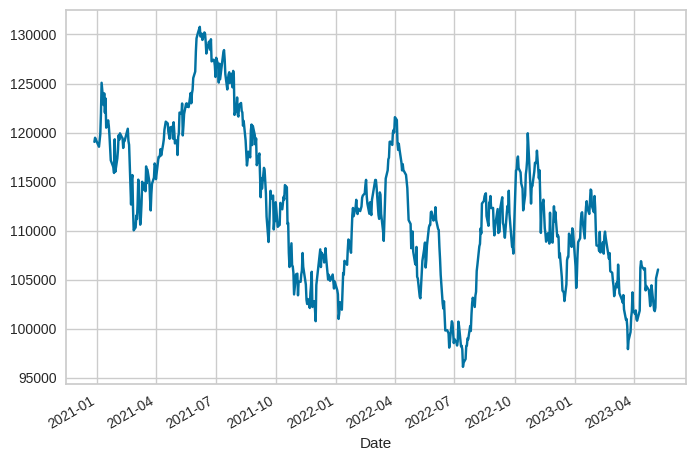

In [13]:
# Importa as bibliotecas yfinance, pandas
import yfinance as yf
import pandas as pd

# Define a data de início e a data de término
start_date = '2020-12-28'
end_date = '2023-05-09'

# Baixa os dados do índice IBOVESPA (^BVSP) no intervalo de datas especificado
stock_data = yf.download("^BVSP", start=start_date, end=end_date)

# Plota o preço de fechamento dos dados baixados
stock_data['Close'].plot()

# Calcula os retornos percentuais diários e remove os valores ausentes (NaN)
# Renomeia a série para 'Y'
stock_data = stock_data['Close'].pct_change().dropna().rename('Y')

# O resultado é uma série de retornos percentuais diários do índice IBOVESPA no intervalo de datas especificado

## Organizar os dados para usar no pycaret

In [14]:
# Cria um DataFrame df_x com a coluna 'date_x' e os dados de text_data
df = text_data.copy()
df_x = pd.DataFrame({'date_x': pd.to_datetime(df.index)})
df.index = range(len(df))
df_x = pd.concat([df_x, df], axis=1).fillna(0)

# Cria um DataFrame df_y com as colunas 'date_y' e 'y' usando os dados de stock_data
df_y = pd.DataFrame({'date_y': pd.to_datetime(stock_data.index),
                     'y': stock_data.values})

# Combina df_x com df_y com base em date_y e no dia anterior mais próximo de x
merged_df = pd.merge_asof(df_y, df_x, left_on='date_y', right_on='date_x', direction='backward')

# Remove a coluna de data redundante
merged_df = merged_df.drop('date_x', axis=1)

# # Imprime o DataFrame resultante
# print(merged_df)

In [15]:
# Preparando os dados para usar no pycaret

# Cria um DataFrame 'data' a partir de 'merged_df'
data = merged_df.copy()

# # Seleciona as últimas 200 linhas do DataFrame para o caso de fazer testes com uma base menor
# data = data.iloc[-200:]

# # Cria uma coluna "index" com as datas correspondentes à coluna 'date_y'
# # (somente se o date_y tiver valores únicos e com frequência clara)
# data["index"] = pd.to_datetime(merged_df['date_y'])

# Cria uma coluna "index" com um conjunto de datas geradas a partir da primeira data de 'date_y'
# com uma frequência diária (freq='D') e um número de períodos igual ao tamanho do dataset.
# (aqui as datas não ficam perfeitas, mas pelo menos não gera erro no pycaret)
data["index"] = pd.DataFrame({'dates': pd.date_range(merged_df['date_y'][0], freq='D', periods=len(data))})['dates']

# Define a variável alvo como "y"
target = "y"

# Remove a coluna "date_y"
data.drop(columns=["date_y"], inplace=True)

# Reseta o índice do DataFrame
data = data.reset_index(drop=True)

# O resultado é o DataFrame 'data' modificado
print(data)

            y  abandonado  abandonar  abater  aberto  abjeto  abolicionista  \
0    0.003561         0.0        0.0     0.0     0.0     0.0            0.0   
1   -0.001415         0.0        0.0     0.0     0.0     0.0            0.0   
2   -0.006270         0.0        0.0     0.0     0.0     0.0            0.0   
3    0.005609         0.0        0.0     0.0     0.0     0.0            0.0   
4    0.005267         0.0        0.0     0.0     0.0     0.0            0.0   
..        ...         ...        ...     ...     ...     ...            ...   
580 -0.023987         0.0        0.0     0.0     0.0     0.0            0.0   
581 -0.001275         0.0        0.0     0.0     0.0     0.0            0.0   
582  0.003703         0.0        0.0     0.0     0.0     0.0            0.0   
583  0.029107         0.0        0.0     0.0     0.0     0.0            0.0   
584  0.008502         0.0        0.0     0.0     0.0     0.0            0.0   

     abominavel  absorvente  absurdo  ...  vivo  vo


# Modelo 1: Previsão com Modelo Clássico sem Texto

Prever os retornos usando apenas um modelo clássico (AUTOARIMA) SEM INCLUIR os termos de notícia

In [34]:
data_uni = data.copy()
data_uni.set_index("index", inplace=True)
data_uni = data_uni[target]

exp_uni = TSForecastingExperiment()
exp_uni.setup(
    data=data_uni, fh=48,
    numeric_imputation_target="ffill", #numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42
)

,Description,Value
0,session_id,42
1,Target,y
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(585, 1)"
5,Transformed data shape,"(585, 1)"
6,Transformed train set shape,"(537, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [35]:
import time
%time modelo_base = exp_uni.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,24))

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-01-25,1.3032,1.2976,0.0169,0.0214,4.3414,1.3740,-1.0713
1,2022-03-14,2.5848,2.4479,0.0344,0.0414,7.6293,1.5643,-6.3330
2,2022-05-01,3.6643,3.3188,0.0499,0.0575,27.8164,1.5831,-17.4637
Mean,NaT,2.5174,2.3547,0.0337,0.0401,13.2624,1.5071,-8.2893
SD,NaT,0.9651,0.8278,0.0135,0.0147,10.3784,0.0945,6.8336


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 1.35 s, sys: 105 ms, total: 1.46 s
Wall time: 10.3 s


On zooming in to the forecasts, we can see that the model is able to capture some of the trends (spikes) in the dataset, but not all. The performance of our baseline model indicates that mean MASE across the CV folds is 1.52 which is not that great. Any value > 1 indicates that the model is performing worse than even a naive model with one step ahead forecasts. This model needs more improvement. Let's see if adding exogenous variables can help improve the model performance.

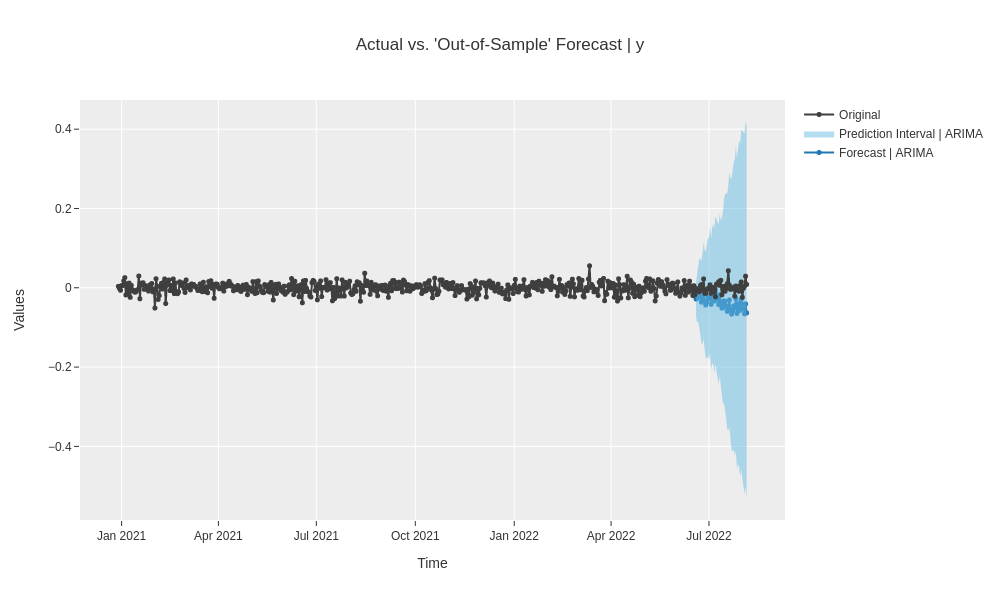

In [36]:
exp_uni.plot_model(modelo_base)

In [37]:
# exp_uni.pull()

## RESULTADO AUTOARIMA SÓ SERIE DE PRECOS (MASE 2.69 e RMSE = 0.0424)

# Modelo 2: Sentimento

https://colab.research.google.com/github/pycaret/pycaret/blob/master/tutorials/time_series/forecasting/univariate_with_exogeneous_part2.ipynb

In [16]:
# Cria um DataFrame df_x com a coluna 'date_x' e os dados de text_data
df = sent_data.copy()
df_x = pd.DataFrame({'date_x': pd.to_datetime(df['data'])})
df.index = range(len(df))
df_x = pd.concat([df_x, df], axis=1).fillna(0)

df_x = df_x.drop(columns=['data'])

# Cria um DataFrame df_y com as colunas 'date_y' e 'y' usando os dados de stock_data
df_y = pd.DataFrame({'date_y': pd.to_datetime(stock_data.index),
                     'y': stock_data.values})

# Combina df_x com df_y com base em date_y e no dia anterior mais próximo de x
merged_sent = pd.merge_asof(df_y, df_x, left_on='date_y', right_on='date_x', direction='backward')

# Remove a coluna de data redundante
merged_sent = merged_sent.drop('date_x', axis=1)

# # Imprime o DataFrame resultante
print(merged_sent)

        date_y         y      sent
0   2020-12-29  0.003561  0.013713
1   2020-12-30 -0.001415 -0.034136
2   2021-01-04 -0.006270  0.093287
3   2021-01-05  0.005609  0.016611
4   2021-01-06  0.005267 -0.017849
..         ...       ...       ...
580 2023-05-02 -0.023987  0.030882
581 2023-05-03 -0.001275 -0.020846
582 2023-05-04  0.003703 -0.012520
583 2023-05-05  0.029107  0.050597
584 2023-05-08  0.008502  0.047889

[585 rows x 3 columns]


In [17]:
# Preparando os dados para usar no pycaret

# Cria um DataFrame 'data' a partir de 'merged_df'
data = merged_sent.copy()

# # Seleciona as últimas 200 linhas do DataFrame para o caso de fazer testes com uma base menor
# data = data.iloc[-200:]

# # Cria uma coluna "index" com as datas correspondentes à coluna 'date_y'
# # (somente se o date_y tiver valores únicos e com frequência clara)
# data["index"] = pd.to_datetime(merged_df['date_y'])

# Cria uma coluna "index" com um conjunto de datas geradas a partir da primeira data de 'date_y'
# com uma frequência diária (freq='D') e um número de períodos igual ao tamanho do dataset.
# (aqui as datas não ficam perfeitas, mas pelo menos não gera erro no pycaret)
data["index"] = pd.DataFrame({'dates': pd.date_range(merged_sent['date_y'][0], freq='D', periods=len(data))})['dates']

# Define a variável alvo como "y"
target = "y"

# Remove a coluna "date_y"
data.drop(columns=["date_y"], inplace=True)

# Reseta o índice do DataFrame
data.set_index("index", inplace=True)
# data = data.reset_index(drop=True)

# O resultado é o DataFrame 'data' modificado
data

,y,sent
index,,
2020-12-29,0.003561,0.013713
2020-12-30,-0.001415,-0.034136
2020-12-31,-0.006270,0.093287
2021-01-01,0.005609,0.016611
2021-01-02,0.005267,-0.017849
...,...,...
2022-08-01,-0.023987,0.030882
2022-08-02,-0.001275,-0.020846
2022-08-03,0.003703,-0.012520


In [18]:
exp_exo = TSForecastingExperiment()
exp_exo.setup(
    data=data, target="y", # index="index",
    fh=48,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42
)

,Description,Value
0,session_id,42
1,Target,y
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(585, 2)"
5,Transformed data shape,"(585, 2)"
6,Transformed train set shape,"(537, 2)"
7,Transformed test set shape,"(48, 2)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [19]:
model_exo = exp_exo.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,24))

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-01-25,1.2981,1.2946,0.0168,0.0214,4.2608,1.3660,-1.0618
1,2022-03-14,2.5875,2.4500,0.0345,0.0414,7.6393,1.5648,-6.3457
2,2022-05-01,3.6700,3.3232,0.0500,0.0575,27.9409,1.5836,-17.5127
Mean,NaT,2.5185,2.3559,0.0338,0.0401,13.2803,1.5048,-8.3067
SD,NaT,0.9696,0.8308,0.0136,0.0148,10.4580,0.0985,6.8577


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [23]:
exp_exo.models()

,Name,Reference,Turbo
ID,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
grand_means,Grand Means Forecaster,sktime.forecasting.naive.NaiveForecaster,True
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
stlf,STLF,sktime.forecasting.trend.STLForecaster,True
croston,Croston,sktime.forecasting.croston.Croston,True
prophet,Prophet,pycaret.containers.models.time_series.ProphetP...,False
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,pycaret.containers.models.time_series.BaseCdsD...,True


In [24]:
import time

# Lista dos modelos específicos a serem incluídos na comparação
# (não rodar arima ou modelos de regressão linear, matriz muito esparsa)
models_to_include = ['naive', 'auto_arima', 'lasso_cds_dt']#, 'ridge_cds_dt', 'en_cds_dt', 'rf_cds_dt', 'gbr_cds_dt', 'xgboost_cds_dt']

# Inicia a contagem do tempo para medir a duração da comparação
# start_time = time.time()

# Compara apenas os modelos especificados
%time best = exp_exo.compare_models(sort="MASE", include=models_to_include, verbose=True)

# Imprime o tempo decorrido para a comparação
# print(f"Tempo decorrido: {time.time() - start_time} segundos")

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
auto_arima,Auto ARIMA,0.8842,0.8749,0.0117,0.0148,1.3514,1.8660,-0.0352,94.7700
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.8969,0.9002,0.0119,0.0152,2.0946,1.5433,-0.1022,3.4400
naive,Naive Forecaster,1.0057,0.9732,0.0133,0.0164,2.7666,1.4953,-0.2769,0.0767


Processing:   0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 3min 13s, sys: 1min 11s, total: 4min 24s
Wall time: 7min 59s


In [ ]:
model_exo = exp_exo.create_model("autoarima", order=(0,1,0), seasonal_order=(0,1,0,24))

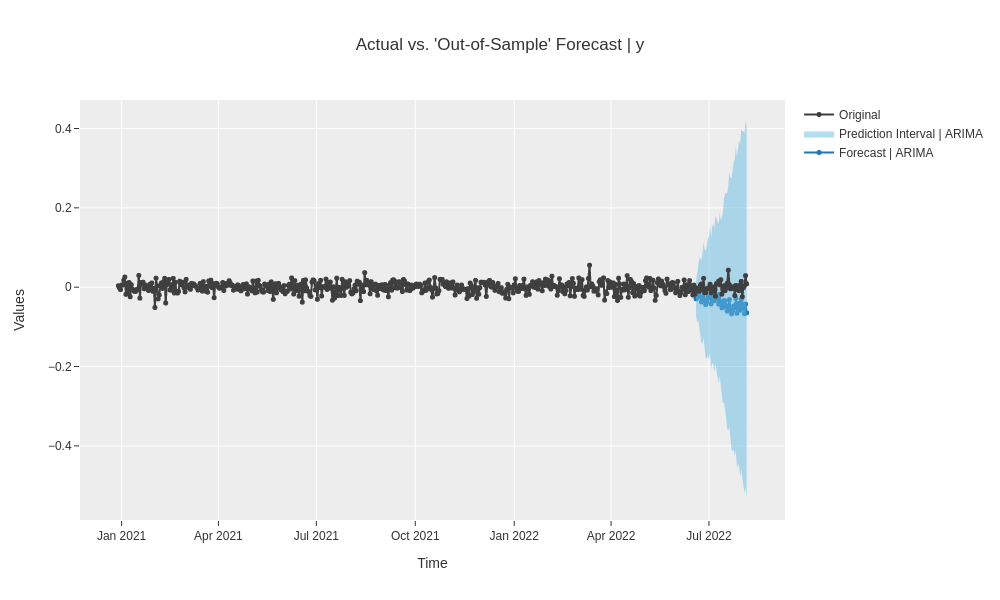

In [20]:
exp_exo.plot_model(model_exo)

In [ ]:
exp_exo.plot_model(model_exo)

# Modelo 3: Previsão usando AutoML com dados textuais

#### Get Data Again (just to review)

In [ ]:
# Preparando os dados para usar no pycaret

# Cria um DataFrame 'data' a partir de 'merged_df'
data = merged_df.copy()

# # Seleciona as últimas 200 linhas do DataFrame para o caso de fazer testes com uma base menor
# data = data.iloc[-200:]

# # Cria uma coluna "index" com as datas correspondentes à coluna 'date_y'
# # (somente se o date_y tiver valores únicos e com frequência clara)
# data["index"] = pd.to_datetime(merged_df['date_y'])

# Cria uma coluna "index" com um conjunto de datas geradas a partir da primeira data de 'date_y'
# com uma frequência diária (freq='D') e um número de períodos igual ao tamanho do dataset.
# (aqui as datas não ficam perfeitas, mas pelo menos não gera erro no pycaret)
data["index"] = pd.DataFrame({'dates': pd.date_range(merged_df['date_y'][0], freq='D', periods=len(data))})['dates']

# Define a variável alvo como "y"
target = "y"

# Remove a coluna "date_y"
data.drop(columns=["date_y"], inplace=True)

# Reseta o índice do DataFrame
data.set_index("index", inplace=True)
# data = data.reset_index(drop=True)

# O resultado é o DataFrame 'data' modificado
data

,y,abandonado,abandonar,abater,aberto,abjeto,abolicionista,abominavel,absorvente,absurdo,...,vitoria,vivo,voraz,votar,vulgaridade,vulnerabilidade,vulneravel,xenofobia,xingar,zelo
index,,,,,,,,,,,,,,,,,,,,,
2020-12-29,0.003561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-30,-0.001415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-31,-0.006270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01,0.005609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-02,0.005267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,-0.023987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-02,-0.001275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-03,0.003703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Tentando resolver que nao esta aparecendo tudo

https://stackoverflow.com/questions/75899490/unable-to-capture-or-show-the-compare-model-metrics-in-streamlit

[link for google search](https://www.google.com/search?q=why+TSForecastingExperiment+compare_models+not+show+all+models&oq=why+TSForecastingExperiment+compare_models+not+show+all+models&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIHCAEQIRigATIHCAIQIRigATIHCAMQIRigATIHCAQQIRigAdIBCTE4Nzk1ajBqMagCALACAA&sourceid=chrome&ie=UTF-8)

**Configurando um o experimento de previsão de séries temporais no PyCaret**


Inicialmente configurar o ambiente de experimentação. Após a configuração, seguiremos com a seleção de modelos, treinamento e avaliação utilizando as funções fornecidas pelo PyCaret.

In [ ]:
# Definir o horizonte de previsão (número de períodos no futuro para prever)
FH = 48

# Definir métrica de avaliação do modelo, neste caso, "mase" (Mean Absolute Scaled Error).
metric = "mase"

In [ ]:
# Cria uma instância de TSForecastingExperiment
exp_auto = TSForecastingExperiment()

# Configura o experimento
exp_auto.setup(
    data=data,  # DataFrame de dados
    target=target,  # Variável alvo
    fh=FH,  # Horizonte de previsão
    enforce_exogenous=False,  # Use previsão multivariada quando o modelo suporta, caso contrário, use previsão univariada
    numeric_imputation_target="ffill",  # Método de imputação numérica para a variável alvo
    # numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings,  # Configurações globais para figuras
    session_id=42  # Identificador de sessão para reproduzibilidade
)

,Description,Value
0,session_id,42
1,Target,y
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(585, 1083)"
5,Transformed data shape,"(585, 1083)"
6,Transformed train set shape,"(537, 1083)"
7,Transformed test set shape,"(48, 1083)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
import time

# Lista dos modelos específicos a serem incluídos na comparação
# (não rodar arima ou modelos de regressão linear, matriz muito esparsa)
models_to_include = ['naive', 'lasso_cds_dt', 'ridge_cds_dt', 'en_cds_dt', 'rf_cds_dt', 'gbr_cds_dt', 'xgboost_cds_dt']

# Inicia a contagem do tempo para medir a duração da comparação
# start_time = time.time()

# Compara apenas os modelos especificados
%time best = exp_auto.compare_models(sort=metric, include=models_to_include, verbose=True)

# Imprime o tempo decorrido para a comparação
# print(f"Tempo decorrido: {time.time() - start_time} segundos")

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.8969,0.9002,0.0119,0.0152,2.0946,1.5433,-0.1022,36.2900
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.8969,0.9002,0.0119,0.0152,2.0946,1.5433,-0.1022,35.2433
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.8997,0.9039,0.0120,0.0153,2.5417,1.5477,-0.1125,35.2500
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.9176,0.9276,0.0122,0.0157,3.6073,1.4979,-0.1695,35.4300
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.9216,0.9178,0.0122,0.0155,2.7564,1.5615,-0.1491,41.3300
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.9457,0.9417,0.0126,0.0159,3.8741,1.4751,-0.2060,41.6300
naive,Naive Forecaster,1.0057,0.9732,0.0133,0.0164,2.7666,1.4953,-0.2769,0.6800


Processing:   0%|          | 0/33 [00:00<?, ?it/s]

CPU times: user 7.28 s, sys: 1.04 s, total: 8.33 s
Wall time: 11min 20s


In [ ]:
# # Check available models ----
# exp_auto.models()

#### RESULTADO INCLUINDO TERMOS (RMSE = 0.0152)

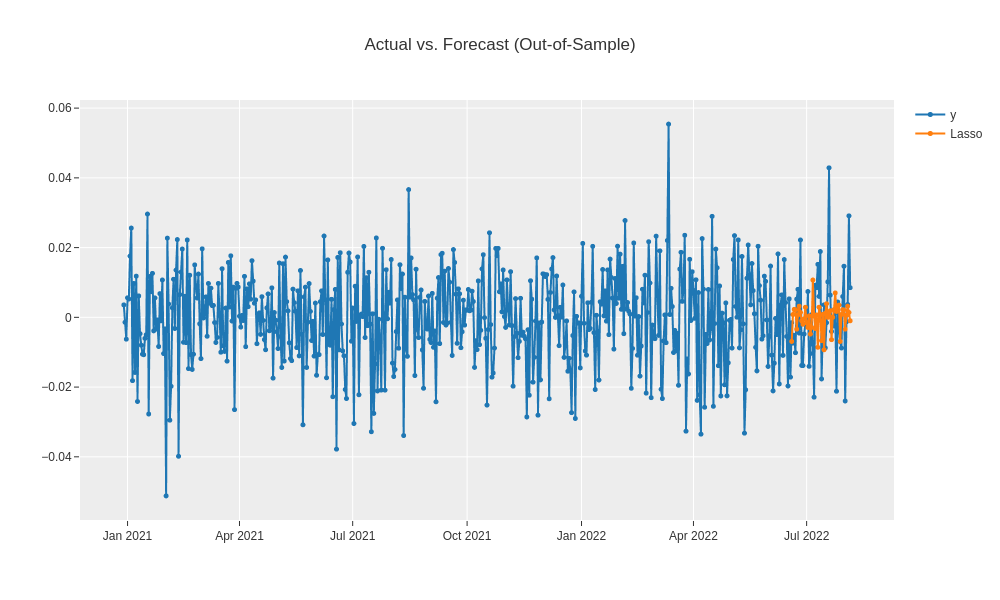

In [ ]:
exp_auto.plot_model(best)

# Resultado da Previsão

- Métricas do Modelo Base
- Métricas dos Modelos de Machine Learning (ML) usando Dados Textuais


In [ ]:
resultado_modelo_base = exp_uni.pull()
resultado_modelo_base

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ARIMA,2.6915,2.3936,0.0374,0.0424,8.6324,1.6025,-10.1425


In [ ]:
resultado_modelo_ml_com_texto = exp_auto.pull()
resultado_modelo_ml_com_texto

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Lasso,0.7275,0.7364,0.0101,0.013,1.3614,1.603,-0.0548


## Ignorar o que vem a seguir

Análise das Palavras Mais Importantes no Modelo de ML

In [ ]:
modelo_naive = exp_auto.create_model('naive')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-01-25,1.0775,1.0392,0.0140,0.0172,4.1806,1.2816,-0.3286
1,2022-03-14,1.1179,1.1052,0.0149,0.0187,2.7729,1.3972,-0.4948
2,2022-05-01,0.8218,0.7752,0.0112,0.0134,1.3462,1.8072,-0.0073
Mean,NaT,1.0057,0.9732,0.0133,0.0164,2.7666,1.4953,-0.2769
SD,NaT,0.1311,0.1426,0.0016,0.0022,1.1572,0.2255,0.2024


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
from pycaret.utils.generic import enable_colab
enable_colab
from pycaret.regression import *

# exp_auto.evaluate_model(modelo_naive)
evaluate_model(modelo_naive)

ValueError: ignored

In [ ]:
modelo_rf = exp_auto.create_model('rf_cds_dt')

In [ ]:
# # launch evaluate widget

# from pycaret.utils.generic import enable_colab
# enable_colab

# # from pycaret.regression import *
# from pycaret.regression import evaluate_model

# evaluate_model(modelo_rf)

In [ ]:
# help(evaluate_model)